In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import joblib
import os
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# ---------------------------
# 1. Load and Preprocess Data
# ---------------------------


# Load data
df = pd.read_excel('Data_GHGE.xlsx')

# Feature selection
feature_columns = [
    'FP index ', 'LP index ', 'Vegetal Pds-FS', 'Cereals -FS', 'Starchy Rts-FS',
    'Pulses-FS', 'Fruits -FS', 'Meat-FS', 'Fish-FS', 'Sugar & Swt-FS', 
    'Oils-FS ', 'Vegetables-FS ', 'Spices-FS', 'Eggs-FS', 'Milk-FS',
    'Cereals-LSF', 'Starchy Rts-LSF', 'Pulses-LSF', 'Meat-LSF', 'Fish-LSF',
    'Cereals-LS', 'Starchy-LS', 'Fruits-LS', 'Energy use', 'Renewable energy '
]

df.columns

Index(['Indicator Code', 'FP index ', 'LP index ', 'Vegetal Pds-FS',
       'Cereals -FS', 'Starchy Rts-FS', 'Pulses-FS', 'Fruits -FS', 'Meat-FS',
       'Fish-FS', 'Sugar & Swt-FS', 'Oils-FS ', 'Vegetables-FS ', 'Spices-FS',
       'Eggs-FS', 'Milk-FS', 'Cereals-LSF', 'Starchy Rts-LSF', 'Pulses-LSF',
       'Meat-LSF', 'Fish-LSF', 'Cereals-LS', 'Starchy-LS', 'Fruits-LS',
       'Energy use', 'Renewable energy ', 'GHGEs ',
       'Agricultural land use share ', 'Agricultural water share ',
       'Surface temp.', 'Overweight', 'Obese', 'Death-NCD ',
       'Life expectancy '],
      dtype='object')

In [3]:
X = df[feature_columns].values
y = df['Agricultural land use share '].values 

# Split data before scaling to prevent data leakage
# X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
#     X, y, test_size=0.15, random_state=42
# )

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.15, random_state=42,
    stratify=pd.qcut(y, q=5, labels=False)
)



# Initialize scalers
feature_scaler = RobustScaler()
target_scaler = RobustScaler()

In [4]:
# Fit scalers on training data
X_train_scaled = feature_scaler.fit_transform(X_train_raw)
y_train_scaled = target_scaler.fit_transform(y_train_raw.reshape(-1, 1))

# Transform test data
X_test_scaled = feature_scaler.transform(X_test_raw)
y_test_scaled = target_scaler.transform(y_test_raw.reshape(-1, 1))

# Create sequences
def create_sequences(X, y, sequence_length=3):
    sequences_X = []
    sequences_y = []
    for i in range(len(X) - sequence_length + 1):
        sequences_X.append(X[i:i+sequence_length])
        sequences_y.append(y[i+sequence_length-1])
    return np.array(sequences_X), np.array(sequences_y)

# Create sequences in training data
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, sequence_length=3)

# Create sequences in test data
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, sequence_length=3)

In [5]:
len(y_test_seq)

8

In [6]:
# 2. Build the Bidirectional LSTM Model
# ---------------------------

from tensorflow.keras.layers import Bidirectional

# Build the model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)),
                  input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.3),
    
    Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.001))),
    Dropout(0.3),
    
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1, activation='linear')
])

C:\Users\Prince\Anaconda3\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
#  Define custom metric
def correlation_coefficient(y_true, y_pred):
    x = y_true - K.mean(y_true)
    y = y_pred - K.mean(y_pred)
    numerator = K.sum(x * y)
    denominator = K.sqrt(K.sum(K.square(x)) * K.sum(K.square(y)))
    return numerator / (denominator + K.epsilon())

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae', correlation_coefficient]
)


In [8]:
# 4. Train the Model
# ---------------------------

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_correlation_coefficient', mode='max', patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)
]

# Train the model
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=200,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - correlation_coefficient: 0.1994 - loss: 0.7867 - mae: 0.5088 - val_correlation_coefficient: 0.7286 - val_loss: 0.8400 - val_mae: 0.5439 - learning_rate: 0.0010
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - correlation_coefficient: 0.4533 - loss: 0.6781 - mae: 0.4644 - val_correlation_coefficient: 0.7427 - val_loss: 0.7217 - val_mae: 0.4959 - learning_rate: 0.0010
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - correlation_coefficient: 0.6069 - loss: 0.5886 - mae: 0.4171 - val_correlation_coefficient: 0.7235 - val_loss: 0.6344 - val_mae: 0.4508 - learning_rate: 0.0010
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - correlation_coefficient: 0.5794 - loss: 0.5480 - mae: 0.3798 - val_correlation_coefficient: 0.7284 - val_loss: 0.5706 - val_mae: 0.4163 - learning_rate: 0.0010
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - correlation_coefficient: 0.6027 - loss: 0.5151 - mae: 0.3386 - val_correlation_coefficient: 0.7355 - va

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - correlation_coefficient: 0.8602 - loss: 0.1638 - mae: 0.1417 - val_correlation_coefficient: 0.9089 - val_loss: 0.2002 - val_mae: 0.2147 - learning_rate: 0.0010
Epoch 35/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - correlation_coefficient: 0.8720 - loss: 0.1588 - mae: 0.1331 - val_correlation_coefficient: 0.9091 - val_loss: 0.1981 - val_mae: 0.2266 - learning_rate: 0.0010
Epoch 36/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - correlation_coefficient: 0.8807 - loss: 0.1435 - mae: 0.1037 - val_correlation_coefficient: 0.9097 - val_loss: 0.1966 - val_mae: 0.2290 - learning_rate: 0.0010
Epoch 37/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - correlation_coefficient: 0.8765 - loss: 0.1472 - mae: 0.1212 - val_correlation_coefficient: 0.9132 - val_loss: 0.1916 - val_mae: 0.2240 - learning_rate: 0.0010
Epoch 38/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - correlation_coefficient: 0.8777 - loss: 0.1397 - mae: 0.1082 - val_correlation_coefficient: 0.9162 - val_los

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - correlation_coefficient: 0.8847 - loss: 0.0947 - mae: 0.1024 - val_correlation_coefficient: 0.9264 - val_loss: 0.1375 - val_mae: 0.1850 - learning_rate: 0.0010
Epoch 68/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - correlation_coefficient: 0.8847 - loss: 0.0899 - mae: 0.0870 - val_correlation_coefficient: 0.9239 - val_loss: 0.1362 - val_mae: 0.1814 - learning_rate: 0.0010
Epoch 69/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - correlation_coefficient: 0.8822 - loss: 0.0902 - mae: 0.0892 - val_correlation_coefficient: 0.9253 - val_loss: 0.1323 - val_mae: 0.1797 - learning_rate: 0.0010
Epoch 70/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - correlation_coefficient: 0.8883 - loss: 0.0859 - mae: 0.0773 - val_correlation_coefficient: 0.9277 - val_loss: 0.1292 - val_mae: 0.1806 - learning_rate: 0.0010
Epoch 71/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - correlation_coefficient: 0.8837 - loss: 0.0904 - mae: 0.0998 - val_correlation_coefficient: 0.9315 - val_los

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - correlation_coefficient: 0.8937 - loss: 0.0608 - mae: 0.0734 - val_correlation_coefficient: 0.9380 - val_loss: 0.1062 - val_mae: 0.1517 - learning_rate: 0.0010
Epoch 101/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - correlation_coefficient: 0.8865 - loss: 0.0656 - mae: 0.0827 - val_correlation_coefficient: 0.9371 - val_loss: 0.1040 - val_mae: 0.1532 - learning_rate: 0.0010
Epoch 102/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - correlation_coefficient: 0.8887 - loss: 0.0624 - mae: 0.0768 - val_correlation_coefficient: 0.9384 - val_loss: 0.1004 - val_mae: 0.1580 - learning_rate: 0.0010
Epoch 103/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - correlation_coefficient: 0.8884 - loss: 0.0627 - mae: 0.0813 - val_correlation_coefficient: 0.9412 - val_loss: 0.0989 - val_mae: 0.1559 - learning_rate: 0.0010
Epoch 104/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - correlation_coefficient: 0.8916 - loss: 0.0601 - mae: 0.0789 - val_correlation_coefficient: 0.9418 - val

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - correlation_coefficient: 0.8876 - loss: 0.0524 - mae: 0.0879 - val_correlation_coefficient: 0.9444 - val_loss: 0.0880 - val_mae: 0.1560 - learning_rate: 5.0000e-04
Epoch 134/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - correlation_coefficient: 0.8877 - loss: 0.0513 - mae: 0.0717 - val_correlation_coefficient: 0.9426 - val_loss: 0.0874 - val_mae: 0.1563 - learning_rate: 5.0000e-04
Epoch 135/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - correlation_coefficient: 0.8878 - loss: 0.0497 - mae: 0.0827 - val_correlation_coefficient: 0.9407 - val_loss: 0.0874 - val_mae: 0.1547 - learning_rate: 5.0000e-04
Epoch 136/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - correlation_coefficient: 0.8902 - loss: 0.0490 - mae: 0.0793 - val_correlation_coefficient: 0.9397 - val_loss: 0.0886 - val_mae: 0.1493 - learning_rate: 5.0000e-04
Epoch 137/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - correlation_coefficient: 0.8874 - loss: 0.0525 - mae: 0.0844 - val_correlation_coefficie

In [9]:
# Evaluate the model
y_pred_scaled = model.predict(X_test_seq)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = target_scaler.inverse_transform(y_test_seq)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

r2 = r2_score(y_test_unscaled, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred))
mae = mean_absolute_error(y_test_unscaled, y_pred)
rmae= np.sqrt(mean_absolute_error(y_test_unscaled, y_pred))
corr_coef = np.corrcoef(y_test_unscaled.flatten(), y_pred.flatten())[0,1]

print("\nTest Metrics:")
print(f"R2: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMAE:{rmae:.4f}")

print(f"\nPrediction Range:")
print(f"Min: {y_pred.min():.4f}, Max: {y_pred.max():.4f}")

print(f"\nCorrelation coefficient: {corr_coef:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Test Metrics:
R2: 0.8805
RMSE: 0.4389
MAE: 0.3115
RMAE:0.5581

Prediction Range:
Min: 44.2226, Max: 47.3778

Correlation coefficient: 0.9445


# Training and validation loss

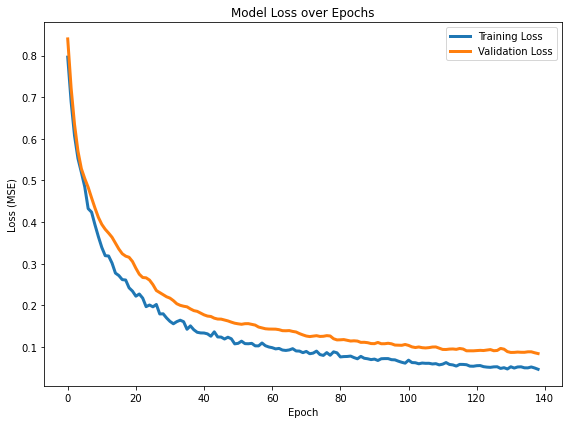

In [10]:
# Plot training & validation loss
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss', linewidth=3)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=3)
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.tight_layout()
# plt.savefig('figures/training_validation_loss.png')
plt.show()

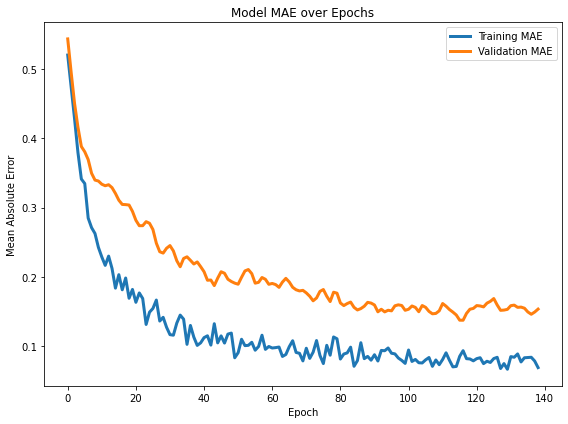

In [11]:
# Plot training & validation MAE
plt.figure(figsize=(8,6))
plt.plot(history.history['mae'], label='Training MAE', linewidth=3)
plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=3)
plt.title('Model MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.tight_layout()
# plt.savefig('figures/training_validation_mae.png')
plt.show()

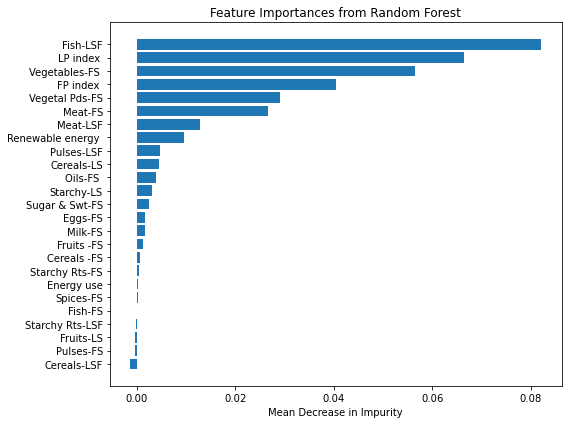

In [12]:
# 8. Additional Visualizations
# ---------------------------

# Feature Importance using Permutation Importance (Optional)
from sklearn.inspection import permutation_importance

# Since LSTM models are not directly compatible with permutation importance,
# we'll use a simple approximation by training a Random Forest as a surrogate model.

from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest on the scaled training data
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train_scaled.ravel())

# Compute permutation importance on the test data
perm_importance = permutation_importance(rf, X_test_scaled, y_test_scaled.ravel(), n_repeats=10, random_state=42)

# Get feature importances
feature_importances = perm_importance.importances_mean

# Plot Feature Importances
sorted_idx = feature_importances.argsort()
plt.figure(figsize=(8,6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(feature_columns)[sorted_idx])
plt.title('Feature Importances from Random Forest')
plt.xlabel('Mean Decrease in Impurity')
plt.tight_layout()
# plt.savefig('figures/feature_importances.png')
plt.show()

# Save the feature importances to a CSV file
feature_importance_df = pd.DataFrame({
    'Feature': np.array(feature_columns)[sorted_idx],
    'Importance': feature_importances[sorted_idx]
})
# feature_importance_df.to_csv('figures/feature_importances.csv', index=False)


In [13]:
# # Save the scalers
# os.makedirs('models', exist_ok=True)
# joblib.dump(feature_scaler, 'scaler.pkl')
# joblib.dump(target_scaler, 'models/target_scaler.save')

# # Save the model
# model.save('models/lstm_life_expectancy.h5')